# Final notebook for Millestone 3

For this last version, we kept our first analysis, and we tried to dig deeper in the following topics:

* [ ] xxxxxxxxxxxx
* [ ] xxxxxxxxxxxx
* [ ] xxxxxxxxxxxx
* [ ] xxxxxxxxxxxx


### imports

In [1]:
!pip install wordcloud regex pyLDAvis vaderSentiment

In [2]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
seed = 42
random.seed(seed)
np.random.seed(seed)

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import gensim
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [3]:
import json
import gzip
import re
import itertools
import regex
import pandas as pd
import gzip
import datetime
import scipy.stats as stats
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

#NLP libraries
import spacy, nltk, sklearn
import pyLDAvis.gensim
from nltk.corpus import stopwords
from typing import Optional
pd.options.mode.chained_assignment = None 

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
# Plot settings
plt.rcParams['figure.dpi'] = 100
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')

# Preproccesing:

As we have a very large dataset containing reviews of all amazon's products in  differents subsets by type:

* Books	
* Electronics	
* Movies and TV	
* CDs and Vinyl	
* Clothing, Shoes and Jewelry	
* Home and Kitchen	
* Kindle Store	
* Sports and Outdoors	
* Cell Phones and Accessories	
* Health and Personal Care	
* Toys and Games	
* Video Games	
* Tools and Home Improvement		
* Beauty	
* Apps for Android	
* Office Products	
* Pet Supplies	
* Automotive	5-core 
* Grocery and Gourmet Food	
* Patio, Lawn and Garden	
* Baby	5-core 
* Digital Music	
* Musical Instruments	
* Amazon Instant Video

For this step, we chose to work with a small subsets to perform our preprocessing, and to have a first idea how efficient it was since we don't handle textual data. We will start by exploring the data, products reviewed and ratings, and try to extract meaningful information, and then we will handle the textual reviews, clean it as much as possible.



* Useful functions for reading data, provided by Amazon.

In [5]:
def parse(path):
    
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Step 1 : Loading the dataset
* Reading the dataset and displaying some important figures.

In [6]:
df = getDF('data/samples/reviews_Pet_Supplies_5.json.gz')
df_copy = df.copy()
# Get some informations about columns
df['reviewText'] = df.reviewText.astype('str')
df['asin'] = df.asin.astype('str')

print(df.dtypes) # type of each attribute 
df = df.dropna()

#df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')
#f.rename(columns={'unixReviewTime':'ReviewTime'},inplace=True)
#df['ReviewTime']

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
dtype: object


In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3.0,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5.0,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4.0,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4.0,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3.0,You really only need vol 2,1330905600,"03 5, 2012"


In [8]:
df.describe()

,overall,unixReviewTime
count,156493.000000,1.564930e+05
mean,4.228585,1.363641e+09
std,1.176669,3.879978e+07
min,1.000000,1.009757e+09
25%,4.000000,1.353542e+09
50%,5.000000,1.373760e+09
75%,5.000000,1.390090e+09
max,5.000000,1.406074e+09


In [9]:
# Basic figures for this sample.
nb_articles = df['asin'].unique().shape[0]
nb_reviewers = df['reviewerName'].unique().shape[0]
nb_reviews = df.shape[0]

print("Number of reviews : %d " % nb_reviews)
print("Number of articles reviewed : %d " % nb_articles)
print("Number of  reviewers  : %d " % nb_reviewers)


Number of reviews : 156493 
Number of articles reviewed : 8508 
Number of  reviewers  : 18070 


### Step 2 : Textual description preprocessing

1.  We try to create a dictionnary of text normalization, wchich can be helpful to substitute incorrect words with correct one. We have two references : 


 * link1( http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/)
 * link2( http://luululu.com/tweet/typo-corpus-r1.txt)


In [10]:
def load_lexical_normalization():
    """
    Function to load lexical normalization dictionaries found online: 
        http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
        http://luululu.com/tweet/typo-corpus-r1.txt
    These dictionaries help perform a spell check on reviews and convert their 
    words to normal english words
    Result: lex_orm : a dictionary, the keys are incorrect words and the values are correct words
    """
    lex_norm = {}
    
    dictionary1 = open('helpers/TextNormalization.txt', 'rb')
    for word in dictionary1:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[1]] = word[3]
    dictionary1.close()
    dictionary2 = open('helpers/TypoCorpus.txt', 'rb')
    for word in dictionary2:
        word = word.decode('utf8')
        word = word.split()
        lex_norm[word[0]] = word[1]
    dictionary2.close()
    return lex_norm
lex_norm = load_lexical_normalization()

def spell_check(review):
    """
    Function that corrects words using the corpus loaded with load_lexical_normalization()
    Arguments: 
        review: a string that represents the raw review
        lexNorm: a dictionary
    Result: a string that represents the corrected review
    """
    review = review.split()
    for i in range(len(review)):
        if review[i] in lex_norm.keys():
            review[i] = lex_norm[review[i]]
    review = ' '.join(review)
    return review


def clean_char_repetitions(review):
    """
    Function that removes repeated letters in words
    """
    
    review=review.split()
    for i in range(len(review)):
        review[i]=''.join(''.join(s)[:2] for _, s in itertools.groupby(review[i])).replace('#', '')

    review=' '.join(review)
    return review

def spell_preprocessing(review):
    ''' 
    Apply the two previous functions
    '''
    review = spell_check(review)
    return clean_char_repetitions(review)




# Add word  adn char count
df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_count,char_count
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3.0,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011",119,590
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5.0,Entertaining for my cats,1379116800,"09 14, 2013",45,217
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4.0,Entertaining,1355875200,"12 19, 2012",84,412
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4.0,Happy to have them,1305158400,"05 12, 2011",57,288
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3.0,You really only need vol 2,1330905600,"03 5, 2012",174,888


### Applying textual preprocessing


In [11]:

df['reviewText'] = df['reviewText'].map(spell_preprocessing)

#Transform reviews to lower case to avoid repetitions of the words.
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing ponctuation
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','')

<input>:8: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \w
<input>:8: DeprecationWarning: invalid escape sequence \w
<ipython-input-11-cfc8c739ec6a>:8: DeprecationWarning: invalid escape sequence \w
  df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','')


In [12]:
# Remove stopwords: that, is, are ..
nltk.download('stopwords')
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/braymond/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
print("List of stopwords filtred: \n ")
print(stop)

List of stopwords filtred: 
 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

In [14]:
#redo the word count 

df['word_count'] = df['reviewText'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['reviewText'].str.len() 

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_count,char_count
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",purchased trilogy hoping two cats age 3 5 woul...,3.0,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011",55,341
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",usually one cats watching tv staying trouble d...,5.0,Entertaining for my cats,1379116800,"09 14, 2013",21,121
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",bought triliogy tested dvds appears volume 2 w...,4.0,Entertaining,1355875200,"12 19, 2012",42,258
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",female kitty could care less videosbut cares l...,4.0,Happy to have them,1305158400,"05 12, 2011",27,161
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]",gotten volume two would given five stars since...,3.0,You really only need vol 2,1330905600,"03 5, 2012",88,542


* We can se that we let go of many unusefull words, and with the remaining one we'll try to conduct the final analysis

### End of Preprocessing



# Next step of textual analysis ( See below 2/F)

* For the next milestone, we're going to go deeper into natural language processing, and try to extract information from the text review or the summary (or both) and identify if there's a causality between high helpfulness and a good comment (review)

# Analysis Step : 
###  A/ Visualisation of data

Let's try and visualize distribution of ratings, We will handle:
1. Global ratings 
2. Mean rating per item
3. Mean rating per reviewer

##############################

1. Global ratings 


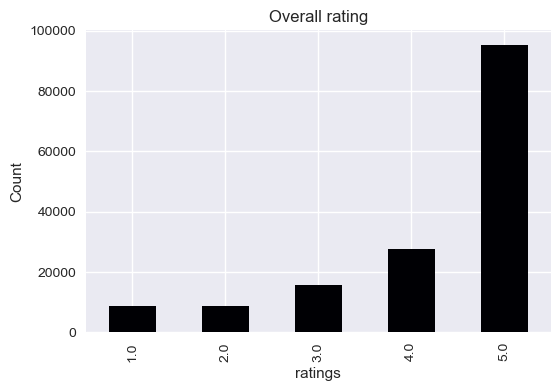

In [15]:
# Plot bins of ratings

summary = df.groupby('overall')['summary'].agg("count")
summary.plot(kind='bar',colormap = 'inferno')
plt.title('Overall rating')
plt.xlabel('ratings')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = [13,6]


In [16]:
summary

overall
1.0     8698
2.0     8844
3.0    15818
4.0    27761
5.0    95372
Name: summary, dtype: int64

We can see that a majority of rating scores are 5. 

In [17]:
gby_product = df.groupby('asin',as_index=False)['overall'].mean()


def get_mean_rating(asin):
    return gby_product[asin]

#df['meanRating'] = df['asin'].map(get_mean_rating)



In [18]:
# Plot the average rating per item


* Visualize reviewers' behavior towards the items

In [19]:
gby_reviewers = df.groupby('reviewerID',as_index=False)['overall'].mean()
gby_reviewers = pd.DataFrame(gby_reviewers)
gby_reviewers.head(5)

,reviewerID,overall
0,A04173782GDZSQ91AJ7OD,4.333333
1,A042274212BJJVOBS4Q85,3.375000
2,A0436342QLT4257JODYJ,5.000000
3,A04795073FIBKY8GSLZYI,3.857143
4,A06658082A27F4VB5UG8E,4.375000


Text(0,0.5,'Count')

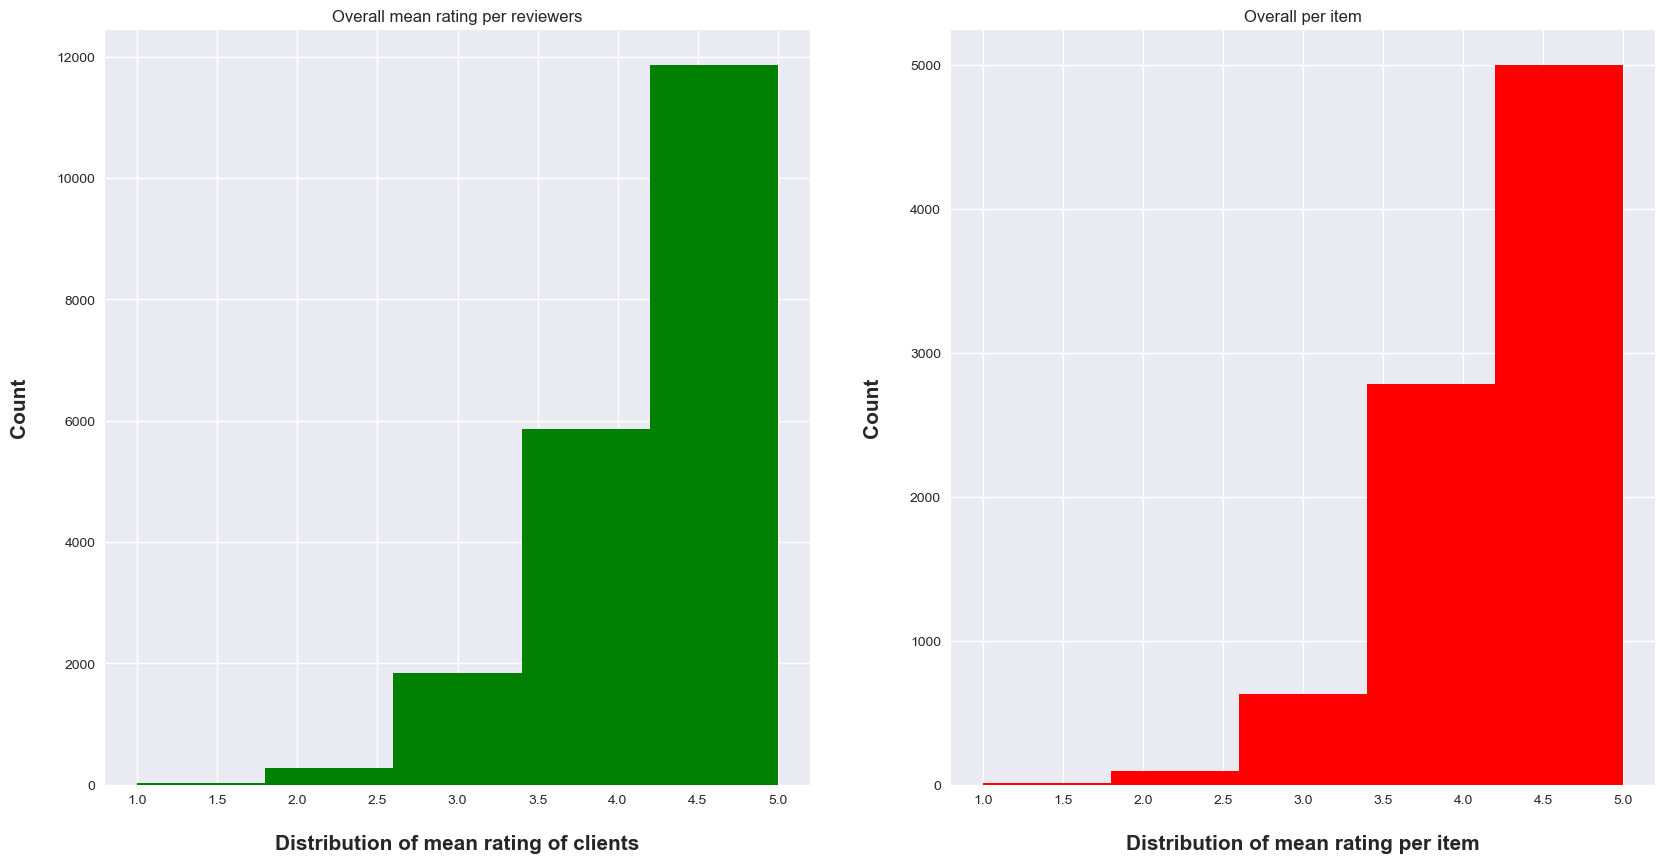

In [20]:
fig, axes = plt.subplots(1, 2,figsize=(20,10))

axes[0].hist(gby_reviewers['overall'], bins=5, facecolor='g')
axes[0].set_title('Overall mean rating per reviewers')
axes[0].set_xlabel('Distribution of mean rating of clients',labelpad=20, weight='bold', size=15)
axes[0].set_ylabel('Count',labelpad=20, weight='bold', size=15)

axes[1].hist(gby_product['overall'], bins=5, facecolor='r')
axes[1].set_title('Overall per item')
axes[1].set_xlabel('Distribution of mean rating per item',labelpad=20, weight='bold', size=15)
axes[1].set_ylabel('Count',labelpad=20, weight='bold', size=15)





In [21]:
mean_rating_items = gby_product['overall'].mean()
mean_rating_reviewers = gby_reviewers['overall'].mean()
mean_rating = df['overall'].mean()

print("Mean rating : %s " %mean_rating)
print("Mean rating per item : %s " %mean_rating_items)
print("Mean rating per reviewer : %s " %mean_rating_reviewers)

Mean rating : 4.228585304135009 
Mean rating per item : 4.214090776132179 
Mean rating per reviewer : 4.233083948807222 


### B/  try to analyze reviewers behavior

We're going to look into the number of reviews given for reviewers and see if there's any relationship between how often they give reviews and the rating they give.

In [22]:
def get_nb_reviews(reviewerID):
    return df[df.reviewerID == reviewerID].shape[0]

#gby_reviewers['nbreviews'] = gby_reviewers['reviewerID'].map(get_nb_reviews)
df['count'] = 1
gby_reviewers['count'] = df.groupby('reviewerID',as_index=False).agg({'count': sum})['count']

gby_reviewers = gby_reviewers.sort_values(by=['overall'],ascending = False)



Text(0.5,1,'Mean ratings vs number of reviews (per person)')

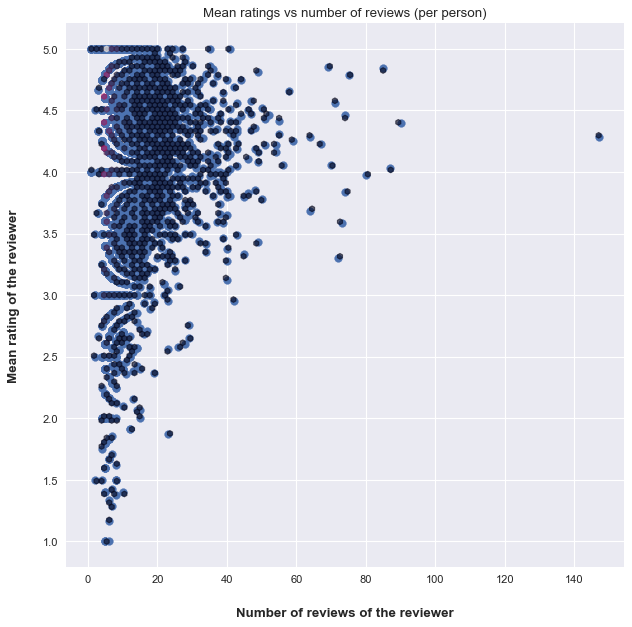

In [23]:
plt.figure(figsize=(9,9), dpi=80)
plt.scatter(gby_reviewers['count'], gby_reviewers.overall)
plt.hexbin(gby_reviewers['count'], gby_reviewers.overall, alpha=.6, mincnt=1)
plt.xlabel('Number of reviews of the reviewer',labelpad=20, weight='bold', size=12)
plt.ylabel('Mean rating of the reviewer',labelpad=20, weight='bold', size=12)
plt.title('Mean ratings vs number of reviews (per person)')


We notice that there is no clear relationship between number of reviews given and the average rating, and yet, we can still see that people who give a lot of reviews tend to rate items correctly, meanwhile people who doesn't often review items (less than 100 reviews) are the majority and hence, they are the decisive part.


### C/  Analysis of helpfulness of reviews


In [24]:
def compute_ratio_help(h):
    if h[1] != 0:
        return 100*h[0] / h[1]
    else:
        return np.nan
    

df['helpful_ratio'] = df['helpful'].map(compute_ratio_help)
df_help = df[['helpful_ratio']].dropna()


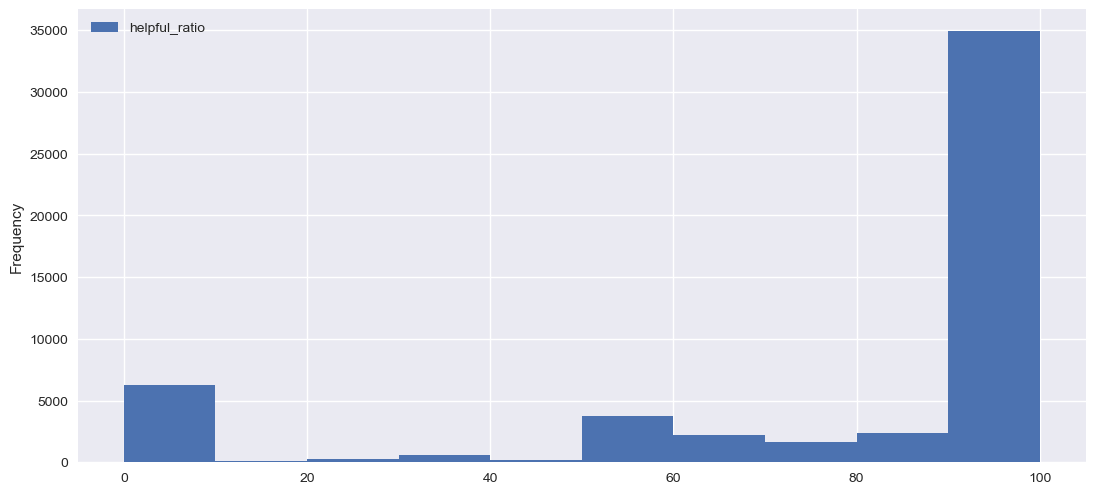

In [25]:
df_help.head()

# Plot distributions of helpfulness
df_help.plot.hist(bins=10)

Helpfulness can be a useful metric for further analysis in the next step, since a majority of reviews can be considered as helpful. We can also extend the analysis to relationship between helpfulness of the review and the textual comment.

### D/ Effect of first reviews on other reviews. (update for Millestone 3)

* We work again with groupedbyItems
* We're going to collect the rating of the first reviews and compare it to the average rating of the item.

### This is one of the main questions we tried to answer, and we will continue to do so when we use the whole dataset, or at least try to find the category of items where this can be considered true.

In [26]:
def get_first_rating(asin):
    
    return df[df.asin == asin].sort_values(by='unixReviewTime')['overall'].iloc[0]
    

gby_product['first_rating'] = gby_product['asin'].map(get_first_rating)
gby_product.head(10)



,asin,overall,first_rating
0,1223000893,3.800000,3.0
1,4847676011,4.800000,5.0
2,9376674824,2.500000,4.0
3,B00002N8FK,4.200000,5.0
4,B00004X14K,3.166667,1.0
5,B0000537O8,4.375000,5.0
6,B00005MF9T,3.333333,5.0
7,B00005MF9U,3.119048,4.0
8,B00005MF9V,2.692308,2.0
9,B00005MF9W,3.625000,3.0


Text(0.5,1,'toto')

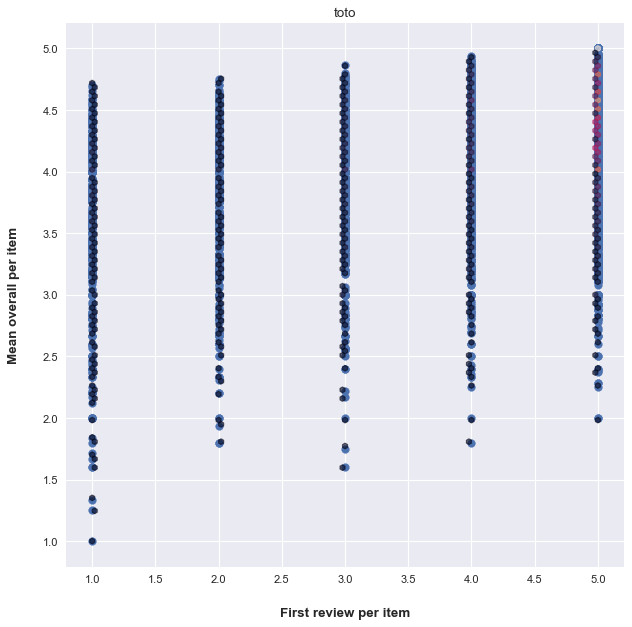

In [27]:
plt.figure(figsize=(9,9), dpi=80)
plt.scatter(gby_product['first_rating'], gby_product.overall)
plt.hexbin(gby_product['first_rating'], gby_product.overall, alpha=.6, mincnt=1)
plt.xlabel('First review per item',labelpad=20, weight='bold', size=12)
plt.ylabel('Mean overall per item',labelpad=20, weight='bold', size=12)
plt.title('toto')


### @todo add conclusion

### E/ Applying sentiment analysis of reviews (update millestone 3)



In [40]:
analyzer = SentimentIntensityAnalyzer()


def extract_sentiment(review):
    vs = analyzer.polarity_scores(review)
    if vs['compound'] >= 0.05:
        sentiment = 'positive'
    elif vs['compound'] <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return sentiment

In [41]:
df['sentiment_review'] = df['reviewText'].map(extract_sentiment)
df['sentiment_summary'] = df['summary'].map(extract_sentiment)

In [42]:
df.to_pickle("./petsupplies/final_df.pkl")
gby_product.to_pickle("./petsupplies/gby_product.pkl")
gby_reviewers.to_pickle("./petsupplies/gby_reviewers.pkl")

In [43]:
#df
#df.to_pickle("./petsupplies/final_df.pkl")
#gby_product.to_pickle("./petsupplies/gby_product.pkl")
#gby_reviewers.to_pickle("./petsupplies/gby_reviewers.pkl")
df = pd.read_pickle("./petsupplies/final_df.pkl")
gby_product = pd.read_pickle("./petsupplies/gby_product.pkl")
gby_reviewers = pd.read_pickle("./petsupplies/gby_reviewers.pkl")

In [44]:
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores("hate")

vs

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5719}

In [45]:
#df['sentiment'] = df['reviewText'].map(extract_sentiment)
#s1 = extract_sentiment(df['reviewText'].iloc[0])
#s1
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,word_count,char_count,count,helpful_ratio,sentiment_review,sentiment_summary
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",purchased trilogy hoping two cats age 3 5 woul...,3.0,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011",55,341,1,NaN,positive,positive
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",usually one cats watching tv staying trouble d...,5.0,Entertaining for my cats,1379116800,"09 14, 2013",21,121,1,NaN,negative,positive
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",bought triliogy tested dvds appears volume 2 w...,4.0,Entertaining,1355875200,"12 19, 2012",42,258,1,NaN,positive,positive
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",female kitty could care less videosbut cares l...,4.0,Happy to have them,1305158400,"05 12, 2011",27,161,1,100.000000,positive,positive
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]",gotten volume two would given five stars since...,3.0,You really only need vol 2,1330905600,"03 5, 2012",88,542,1,85.714286,positive,neutral


In [46]:
sent_review = df[['overall', 'sentiment_review']]
sent_summary = df[['overall', 'sentiment_summary']]

### Analysis of reviews's sentiment

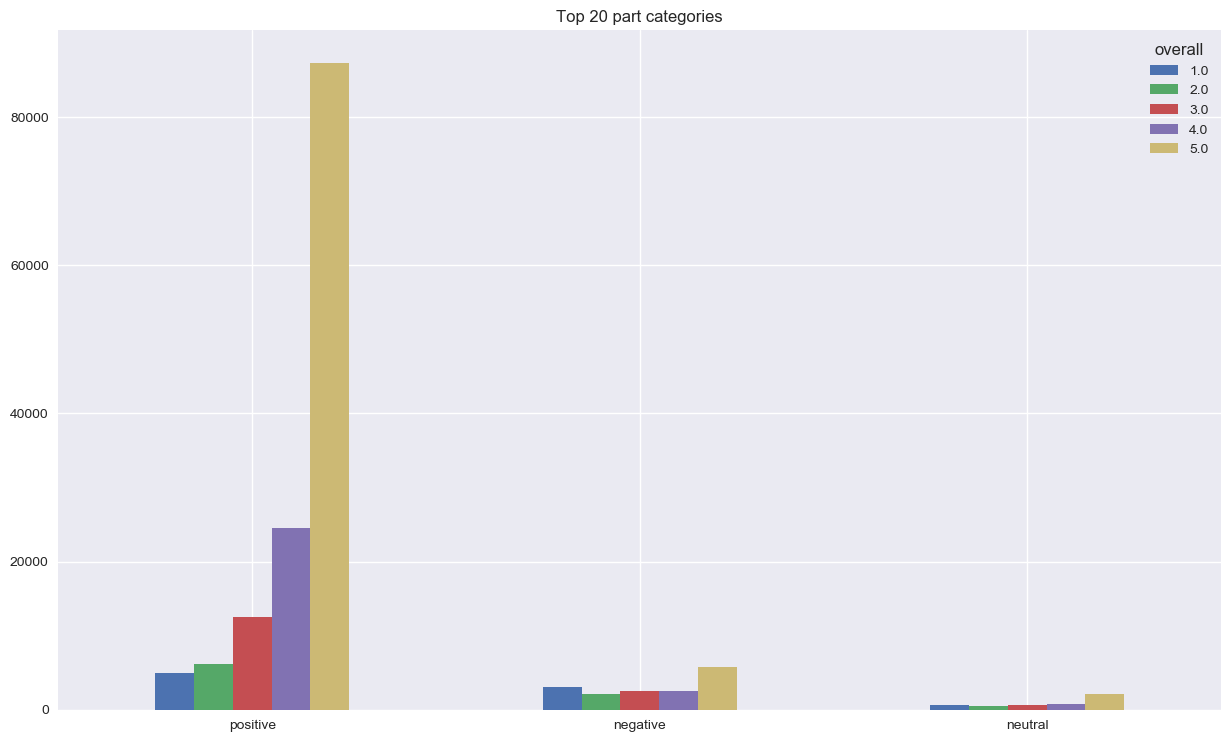

In [47]:

sent_review['count'] = 1
pos = sent_review[sent_review.sentiment_review =='positive']
neg = sent_review[sent_review.sentiment_review =='negative']
neut = sent_review[sent_review.sentiment_review =='neutral']

grouped = pos.groupby('overall').agg({'count': sum})
grouped_neg = neg.groupby('overall').agg({'count': sum})
grouped_neut = neut.groupby('overall').agg({'count': sum})
grouped['negative'] = grouped_neg['count']
grouped['neutral'] = grouped_neut['count']
grouped = grouped.rename(index=str, columns={"count": "positive"})
grouped.T.plot(kind='bar', rot=0, figsize=(15,9), title="Top 20 part categories")
#todo : for two other categories

### Analysis of sumamry's sentiment

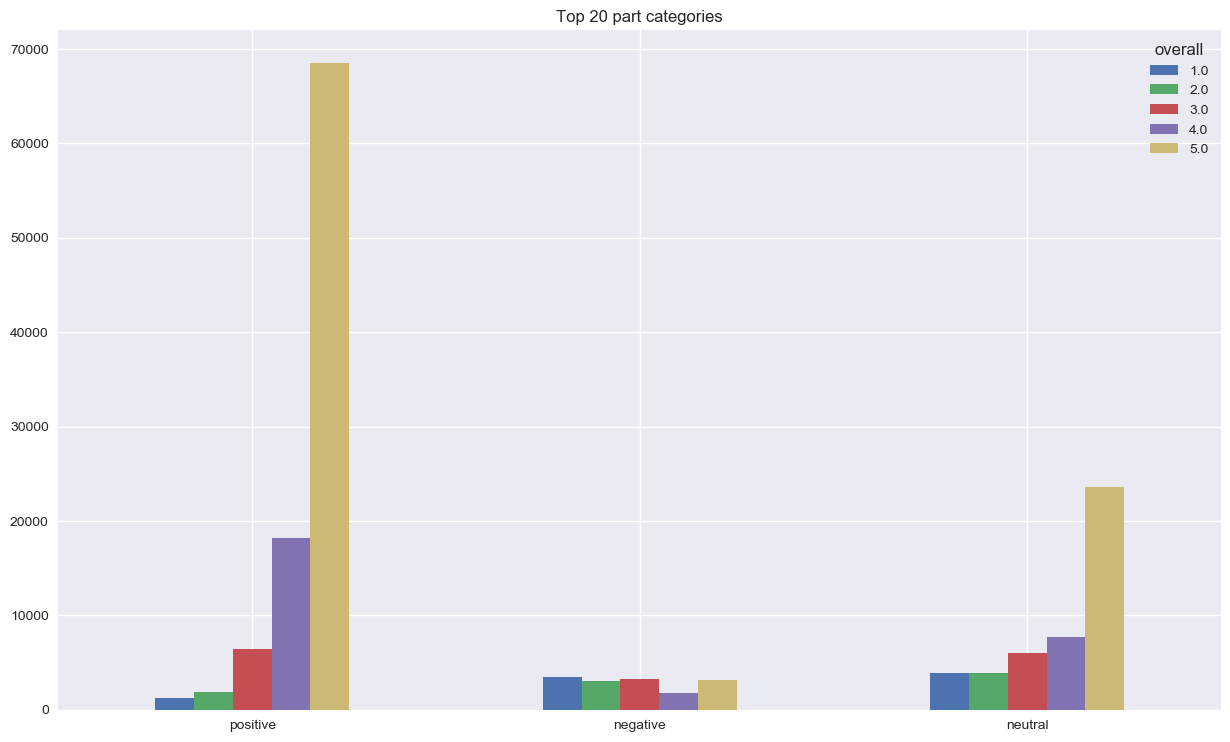

In [48]:

sent_summary['count'] = 1
pos = sent_summary[sent_summary.sentiment_summary =='positive']
neg = sent_summary[sent_summary.sentiment_summary =='negative']
neut = sent_summary[sent_summary.sentiment_summary =='neutral']

grouped = pos.groupby('overall').agg({'count': sum})
grouped_neg = neg.groupby('overall').agg({'count': sum})
grouped_neut = neut.groupby('overall').agg({'count': sum})
grouped['negative'] = grouped_neg['count']
grouped['neutral'] = grouped_neut['count']
grouped = grouped.rename(index=str, columns={"count": "positive"})
grouped.T.plot(kind='bar', rot=0, figsize=(15,9), title="Top 20 part categories")
#todo : for two other categories


### let's find out how many of reviews' sentiment prediction match summaries' sentiment prediction, and explore the misleaging cases

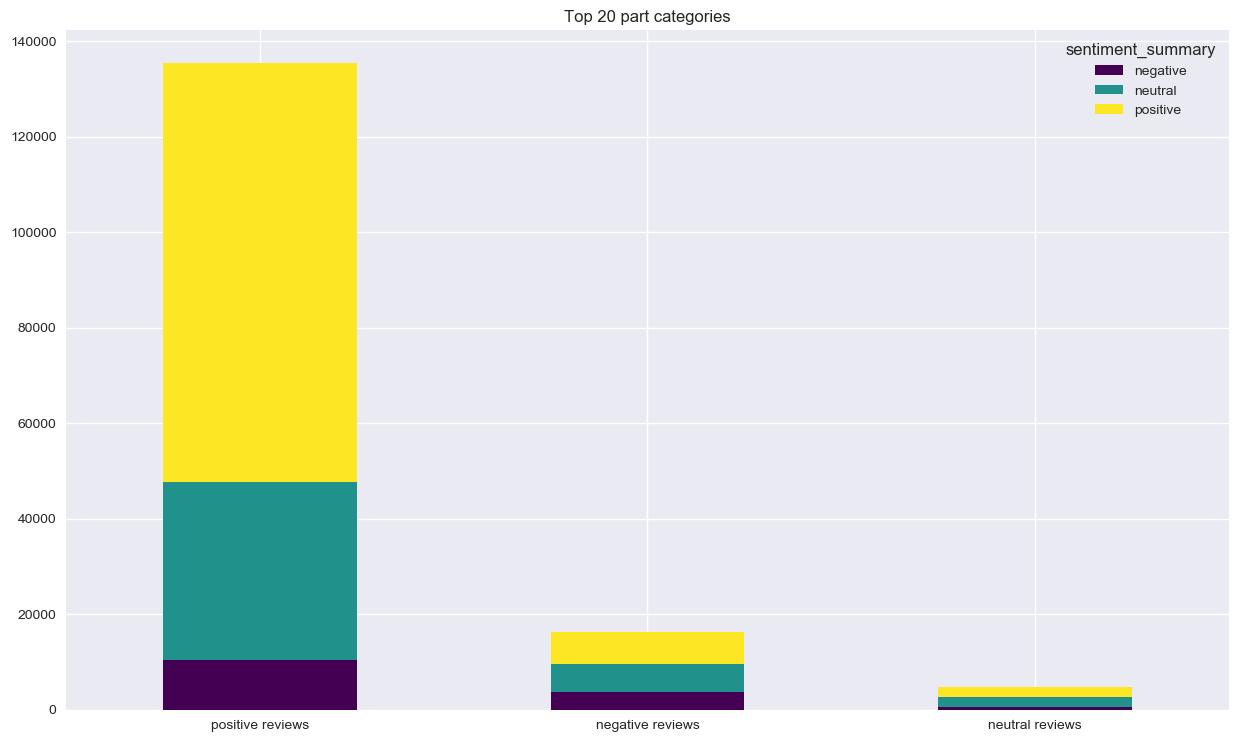

In [49]:
grouped = df[df.sentiment_review == 'positive']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final = grouped.copy()

final = final.rename(index=str, columns={"count": "positive reviews"})
grouped = df[df.sentiment_review == 'negative']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final['negative reviews'] = grouped['count']
grouped = df[df.sentiment_review == 'neutral']
grouped = grouped.groupby('sentiment_summary')['count'].agg({'count': sum})
final['neutral reviews'] = grouped['count']
final.T.plot(kind='bar', stacked=True, rot=0, figsize=(15,9), colormap = 'viridis', title="Top 20 part categories")


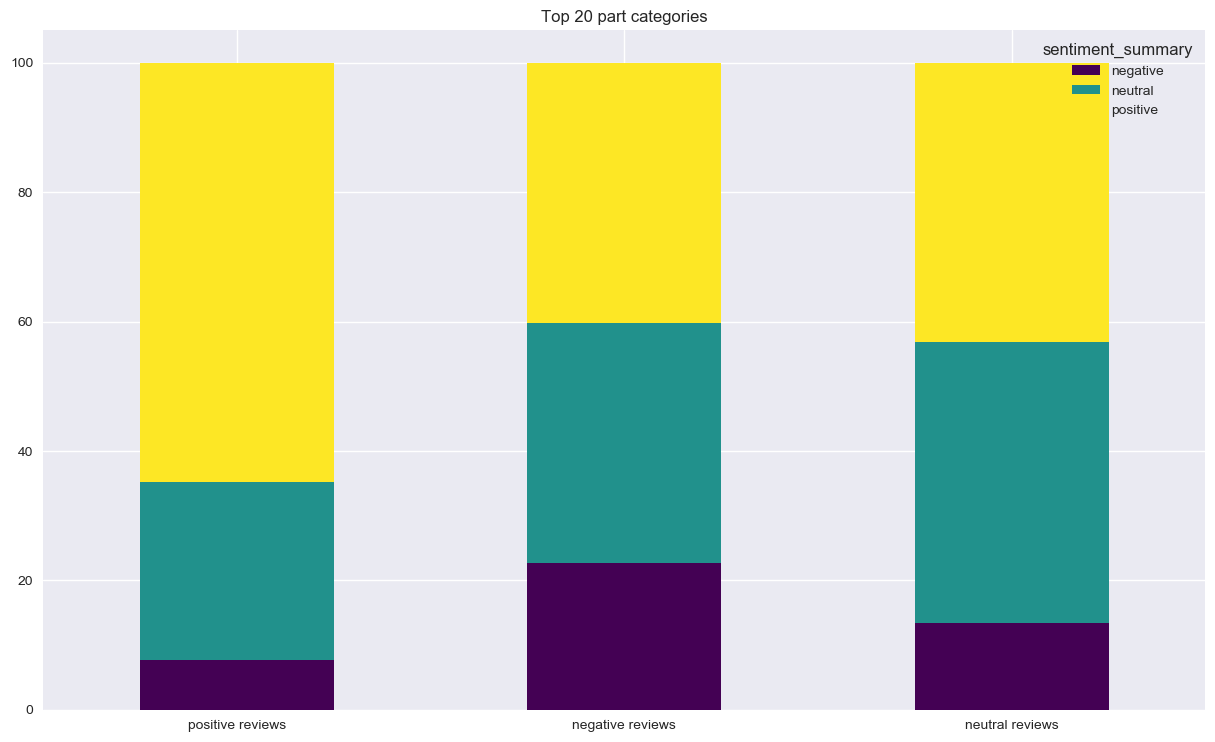

In [50]:
# Let's normalise the data

final['positive reviews'] = 100 * final['positive reviews'] / final['positive reviews'].sum()
final['negative reviews'] = 100 * final['negative reviews'] / final['negative reviews'].sum()
final['neutral reviews'] = 100 * final['neutral reviews'] / final['neutral reviews'].sum()
final.T.plot(kind='bar', stacked=True, rot=0, figsize=(15,9),colormap = 'viridis', title="Top 20 part categories")


### At this stage, we're going to focus on the  negative reviews, and try to understand why 40% of them has a positive prediction based on the summary. We're going to visualize the most frequent words of their summaries.

In [51]:
neg_pos = df[df.sentiment_review =='negative']
neg_pos = neg_pos[neg_pos.sentiment_summary =='positive']
#neg_pos = neg_pos['summary'].values.tolist()




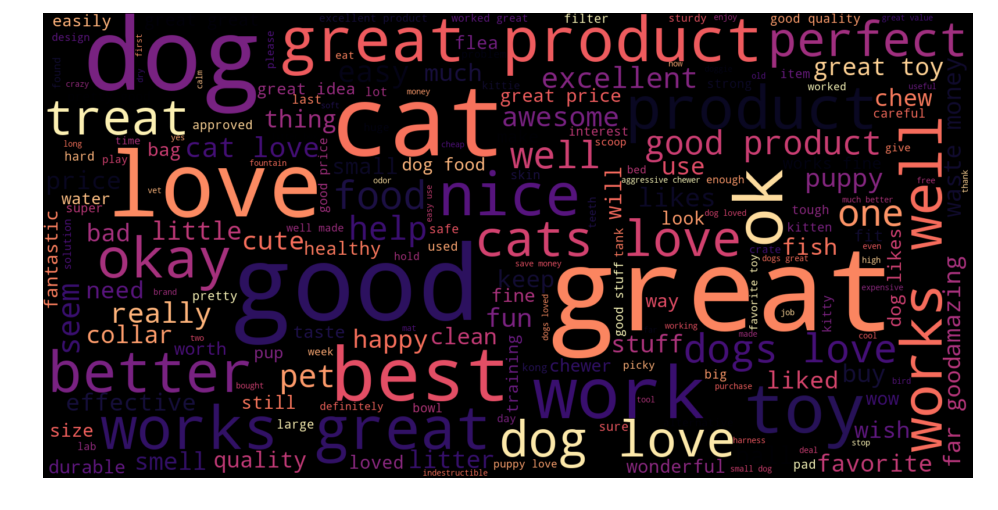

In [52]:
summaries = []
for t in neg_pos.summary:
    summaries.append(t.lower())
summaries = pd.Series(summaries).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,background_color='black',colormap='magma',max_words=200).generate(summaries)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()




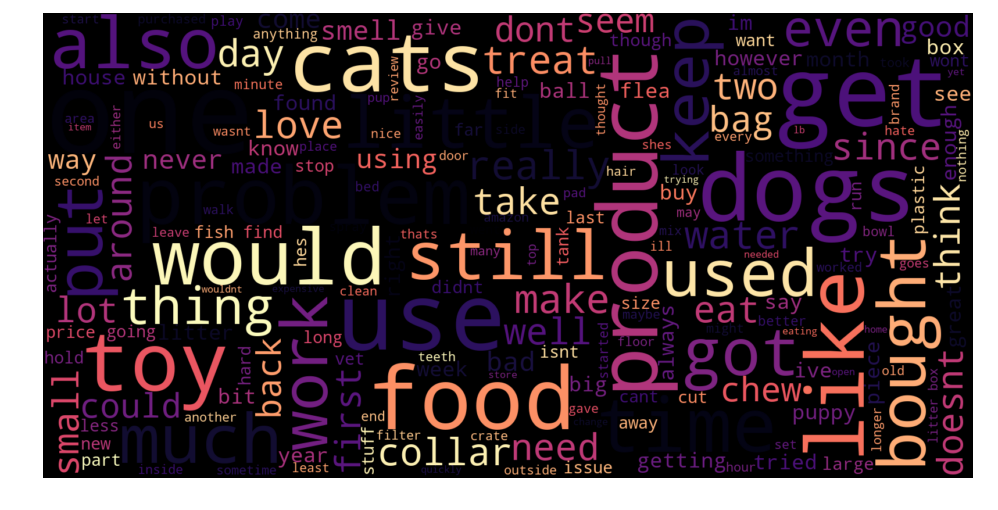

In [53]:
reviews = []
for t in neg_pos.reviewText:
    reviews.append(t.lower())
reviews = pd.Series(reviews).str.cat(sep=' ')
stop_w = ['cat','dog','pet']
wordcloud = WordCloud(width=1600,stopwords = stop_w,  height=800,max_font_size=200,background_color='black',colormap='magma',max_words=200).generate(reviews)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Let's see the ratings associated to these reviews

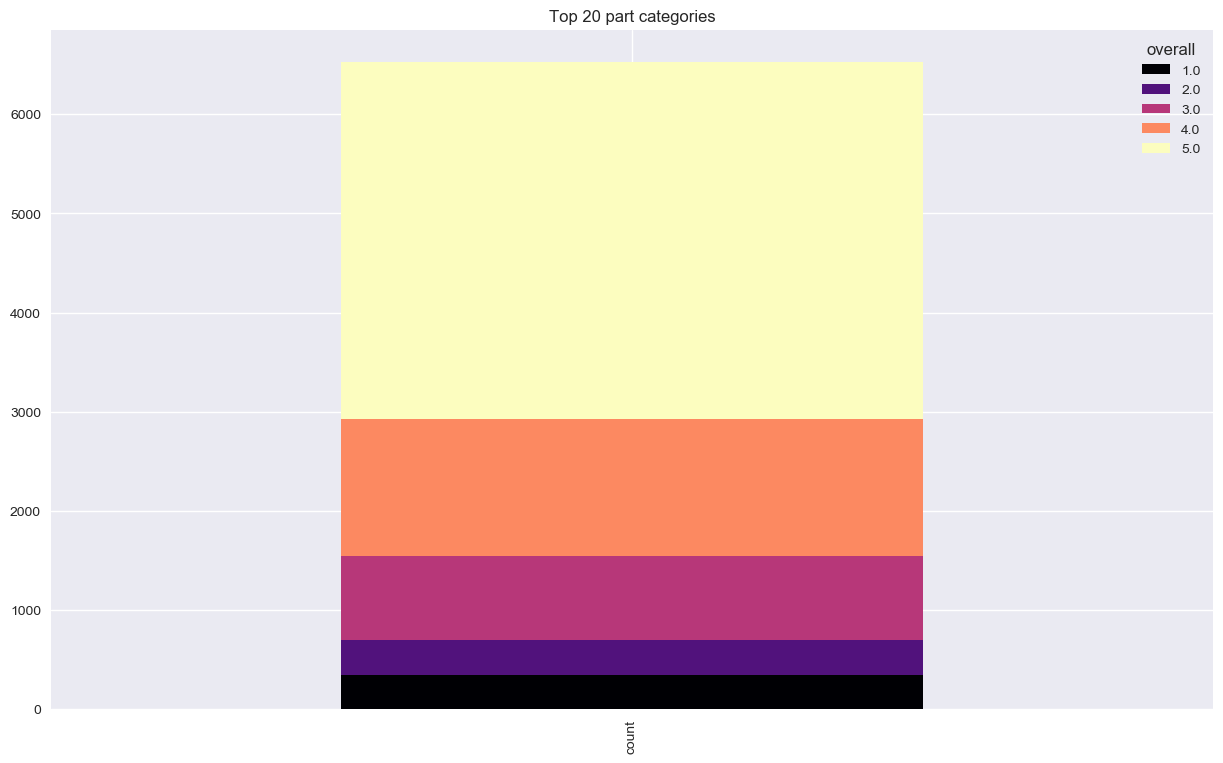

In [54]:
#todo : for two other categories
grouped = neg_pos.groupby('overall').agg({'count': sum})
grouped.T.plot(kind='bar',stacked=True, figsize=(15,9), title="Top 20 part categories",colormap='magma')


In [55]:
neg_5 = neg_pos[neg_pos.overall == 5][['reviewText','summary']]
neg_5['reviewText'].iloc[0]
#Misleading information

# Let's see now the examples with ratings "1", which can say that the positive summary text was misleading
neg_1 = neg_pos[neg_pos.overall == 1][['reviewText','summary']]
neg_1['summary'].iloc[4]

# Sarcaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasm + errors + complaining

"Doesn't work, waste of money!"

### Conclusion : The summary is way more meaningful in term of sentiment analysis, because it's short and then there are less chances to make mistakes in predictions, and also because the reviews with positive summary and negative review have a good rating ( usually 5 or 4 ), that's why we're going to focus more on it in building a classifier to confirm our conclusionv

We're going to consider that a review with a rating of 5 or 4 means a positive sentiment, 3 as neutral and 2 and 1 as positive. 

In [61]:
def to_sentiment(overall):
    if overall >= 4:
        sent = 1
    else:
        sent = 0
    return sent
classif = df[['summary','overall']]
classif['overall'] = classif['overall'].map(to_sentiment)


In [62]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Convolution1D
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.layers.recurrent import GRU

In [63]:
# We split our data into train and test: 70% for training and 30% for testing
msk = np.random.rand(len(df)) <= 0.7

train_set = classif[msk]
test_set = classif[~msk]
test_set

,summary,overall
0,Nice Distraction for my cats for about 15 minutes,0
1,Entertaining for my cats,1
3,Happy to have them,1
4,You really only need vol 2,0
8,Brushing those teeth isn't so hard with this d...,1
12,Poop! Ugh!,0
13,Mixed Results,1
24,Feed the birds,1
27,"Blitz is Good sturdy product, attractive color...",0
30,Great product but not the size described!,0


In [65]:
# At this stage, we tain keras tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train_set['summary'].values)
dict_token = tokenizer.word_index # To see the dicstionary of words kept

# We store the number of features of the neural net since we havent' fixed it in tokenization
nb_features = len(dict_token)

#Converting tweets to sequences and then padding them
train_sequences = tokenizer.texts_to_sequences(train_set['summary'].values)
train_sequences_pad = sequence.pad_sequences(train_sequences, maxlen=30)

test_sequences = tokenizer.texts_to_sequences(test_set['summary'].values)
test_sequences_pad = sequence.pad_sequences(test_sequences, maxlen=30)

# Labels
labels = train_set['overall'].values

# building the model
embed_dim = 50
lstm_out = 100
model = Sequential()
model.add(Embedding( nb_features+1, embed_dim,input_length = train_sequences_pad.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


#Fitting the model to training data
model.fit(train_sequences_pad, labels, validation_split=0.1, epochs=1, batch_size=128, verbose=1)

train_lstm = model.predict_proba(train_sequences_pad, batch_size=128)
test_lstm = model.predict_proba(test_sequences_pad, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 50)            791700    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 852,201
Trainable params: 852,201
Non-trainable params: 0
_________________________________________________________________
None
Train on 98586 samples, validate on 10955 samples
Epoch 1/1
98586/98586 [==============================] - 25s 249us/step - loss: 0.3424 - acc: 0.8569 - val_loss: 0.3087 - val_acc: 0.8736


In [66]:
import _pickle as cPickle

test_lstm
#Saving data to disk
cPickle.dump(train_lstm, open('train_lstm.dat', 'wb'))
cPickle.dump(test_lstm, open('test_lstm.dat', 'wb'))

# @TODO comment

#### Conclusion of this phase of descriptive analysis

1. We had some issues working with the whole dataset, so we chose to work firstly with a sample as a way to explore the data, and then we realised that many of questions we tried to work on are pretty hard to handle since we do not have enough to conclude. Yet, we still can work in depth concerning the influence of first reviews on the following ones.

2. We needed more knowledge about NLP to work with textual data since it represesents more than 70% of the data, we believe that it can be useful in next step

3. As for customer's behavior, we couldn' do much on a subset but if we ask for metadata (From the responsibles) we can work on it easily.

4. until Next step, we will choose two axis of analysis and drop the others because it became hard to focus on one or two ideas, we will do that in very soon to start looking towards the real analysis.